<a href="https://colab.research.google.com/github/Jaesu26/dacon-temp/blob/main/2024-02-04-%EA%B3%A0%EA%B0%9D-%EB%8C%80%EC%B6%9C%EB%93%B1%EA%B8%89-%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 고객 대출 등급 분류 AI 경진대회

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

## 데이터 불러오기

In [2]:
import os
import random
import warnings

import easydict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
sns.set_theme(style="white")
plt.rc("font", family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
from google.colab import drive

drive.mount("/content/drive")  # 구글코랩과 구글드라이브 연결

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/고객-대출등급-분류

/content/drive/MyDrive/Colab Notebooks/고객-대출등급-분류


In [5]:
pd.set_option("display.float_format", "{:.3f}".format)

- 데이터 불러오기

In [316]:
df = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

In [317]:
df = df.drop("ID", axis=1)
test = test.drop("ID", axis=1)

In [318]:
df.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,96294.000,96294.000,96294.000,96294.000,96294.000,96294.000,96294.000,96294.000,96294.000
mean,18303998.068,93926724.678,19.380,25.305,0.346,822503.486,428228.248,54.381,0.006
std,10329075.611,99568708.177,33.570,12.089,0.919,1027745.264,440211.076,1414.769,0.080
min,1200000.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000
25%,10200000.000,57600000.000,12.650,17.000,0.000,307572.000,134616.000,0.000,0.000
50%,16800000.000,78000000.000,18.740,24.000,0.000,597696.000,287004.000,0.000,0.000
75%,24000000.000,112800000.000,25.540,32.000,0.000,1055076.000,570216.000,0.000,0.000
max,42000000.000,10800000000.000,9999.000,169.000,30.000,41955936.000,5653416.000,75768.000,4.000


`-` 대출 금액의 최댓값은 42000000이다

In [10]:
test.shape

(64197, 13)

In [11]:
df["대출등급"].value_counts().sort_index()

A    16772
B    28817
C    27623
D    13354
E     7354
F     1954
G      420
Name: 대출등급, dtype: int64

`-` 주어진 데이터에선 A등급이 최상, G등급이 최하이다

`-` 데이터 불균형이 심하다

`-` 평가지표가 `macro f1`이므로 모든 범주에 대하여 높은 정확도를 보여야 좋은 점수를 얻을 수 있다

## 시각화

In [320]:
df["상환비율"] = df["총상환원금"] / df["대출금액"]
df["대출금액대비상환이자"] = df["총상환이자"] / df["대출금액"]

test["상환비율"] = test["총상환원금"] / test["대출금액"]
test["대출금액대비상환이자"] = test["총상환이자"] / test["대출금액"]

In [161]:
grade_order = sorted(df["대출등급"].unique())

- 상환 비율

<Axes: xlabel='대출등급', ylabel='상환비율'>

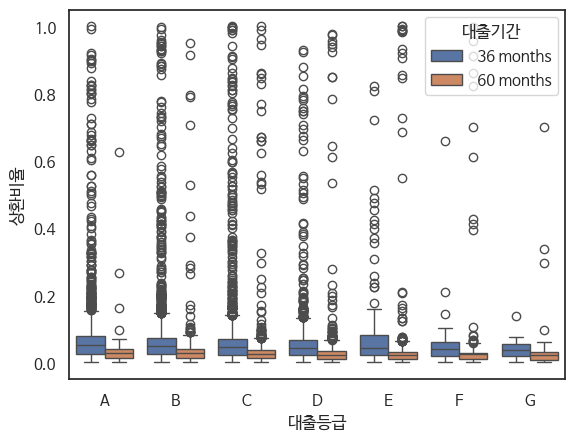

In [63]:
sns.boxplot(data=df, x="대출등급", y="상환비율", hue="대출기간", order=grade_order)

`-` 등급이 우수할수록 평균적으로 대출금을 많이 갚았다

- 대출 금액 대비 상환 이자

<Axes: xlabel='대출등급', ylabel='대출금액대비상환이자'>

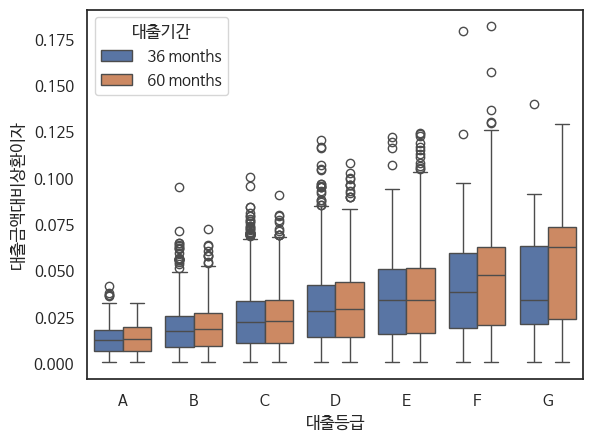

In [64]:
sns.boxplot(data=df, x="대출등급", y="대출금액대비상환이자", hue="대출기간", order=grade_order)

`-` 등급이 낮을수록 이자를 평균적으로 많이 갚는다

- 대출 금액

<Axes: xlabel='대출등급', ylabel='대출금액'>

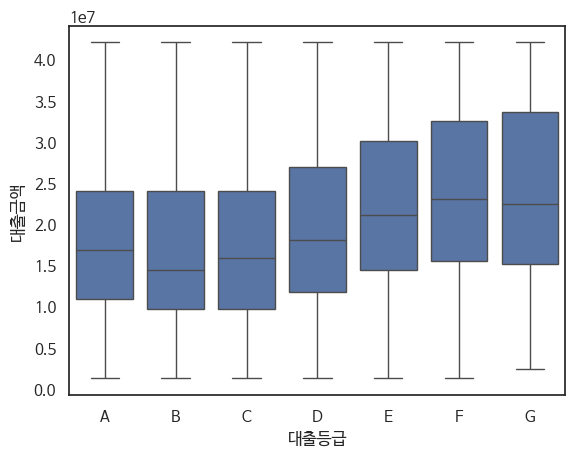

In [13]:
sns.boxplot(data=df, x="대출등급", y="대출금액", order=grade_order)

`-` 대출 등급이 낮을수록 대출 금액이 평균적으로 큰 경향이 있다

- 대출 기간

In [14]:
pd.crosstab(df["대출등급"], df["대출기간"])

대출기간,36 months,60 months
대출등급,,
A,15952,820
B,22883,5934
C,16935,10688
D,6485,6869
E,1895,5459
F,270,1684
G,59,361


<Axes: xlabel='대출기간', ylabel='대출금액'>

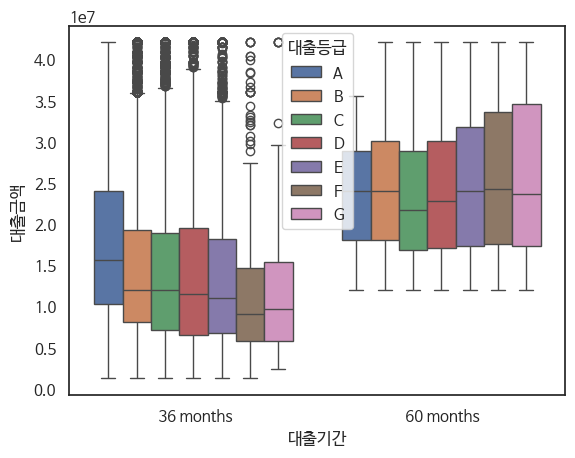

In [15]:
sns.boxplot(data=df, x="대출기간", y="대출금액", hue="대출등급", hue_order=grade_order)

`-` 대출 기간과 대출 등급은 서로 관련이 있다

`-` 대출 기간에 따라 대출 등급의 분포가 다르다

`-` 하나의 대출 기간에 대하여 대출 등급에 따라 대출 금액의 분포가 A 등급의 경우 다르다

`-` 대출 등급별로 대출 가능한 상품이 구분되어 있을텐데 그 것이 위와 같이 나타난 것 같다

- 연간 소득

In [31]:
df.query("연간소득 > 2e8").shape[0]

4076

<Axes: xlabel='대출등급', ylabel='연간소득'>

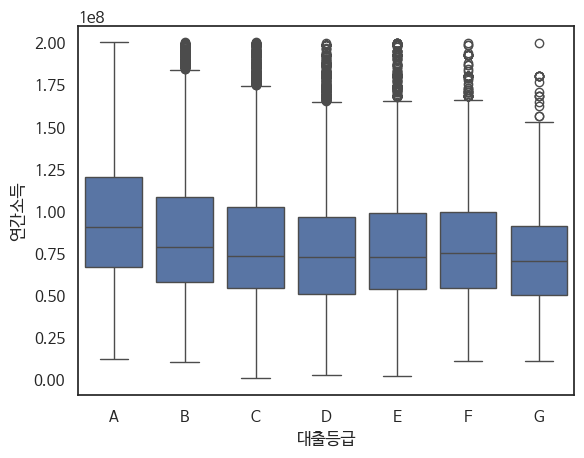

In [17]:
sns.boxplot(data=df.query("연간소득 < 2e8"), x="대출등급", y="연간소득", order=grade_order)

`-` 대출 등급이 우수할수록 연간 소득이 평균적으로 더 많다

- 주택 소유 상태

In [19]:
df["주택소유상태"].value_counts()

MORTGAGE    47934
RENT        37705
OWN         10654
ANY             1
Name: 주택소유상태, dtype: int64

In [20]:
pd.crosstab(df["대출등급"], df["주택소유상태"])

주택소유상태,ANY,MORTGAGE,OWN,RENT
대출등급,,,,
A,0,9640,1864,5268
B,0,14518,3099,11200
C,1,13106,3038,11478
D,0,6163,1538,5653
E,0,3452,846,3056
F,0,883,216,855
G,0,172,53,195


<Axes: xlabel='주택소유상태', ylabel='대출금액'>

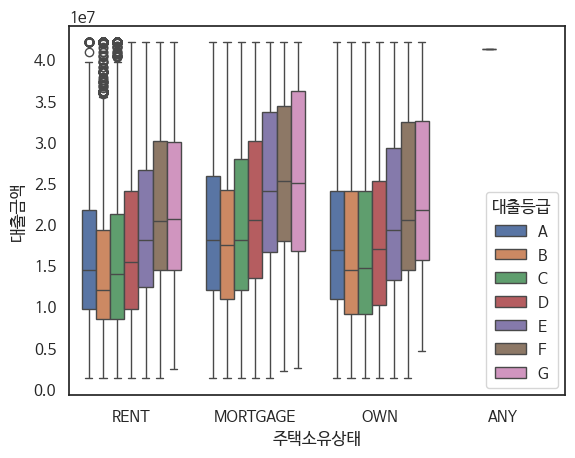

In [22]:
sns.boxplot(data=df, hue="대출등급", y="대출금액", x="주택소유상태", hue_order=grade_order)

`-` 주택 소유 상태 별로 대출 등급에 따른 대출 금액의 분포가 겹쳐있어 구분하기 쉽지 않다

`-` 하지만 MORTGAGE의 경우, 평균적으로 대출 금액이 더 높다

`-` 범주를 MORTGAGE인지 아닌지로 나누는게 좋아보인다

- 부채 대비 소득 비율

In [30]:
df.query("부채_대비_소득_비율 > 50").shape[0]

19

<Axes: xlabel='대출등급', ylabel='부채_대비_소득_비율'>

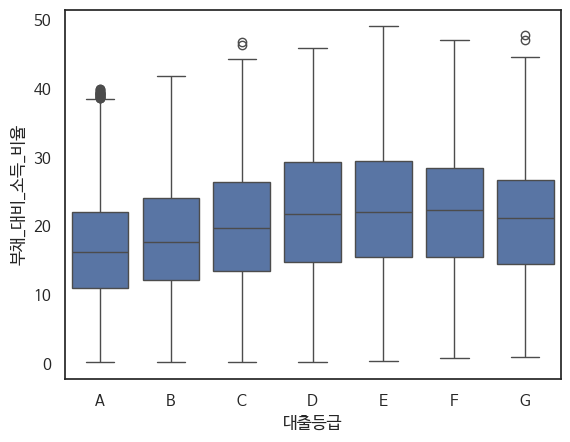

In [24]:
sns.boxplot(data=df.query("부채_대비_소득_비율 < 50"), x="대출등급", y="부채_대비_소득_비율", order=grade_order)

`-` 대출 등급이 우수할수록 부채 대비 소득 비율이 평균적으로 더 작다

<Axes: xlabel='대출기간', ylabel='총상환원금'>

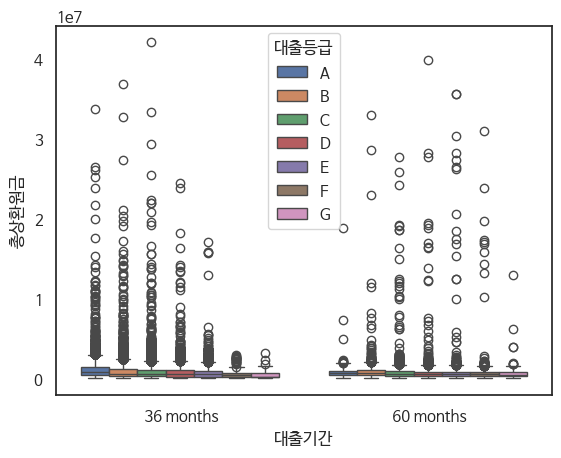

In [60]:
sns.boxplot(data=df, x="대출기간", y="총상환원금", hue="대출등급", hue_order=grade_order)

`-` 대출 등급이 우수할수록 평균적으로 원금을 많이 갚았다

- 총 상환 이자

<Axes: xlabel='대출기간', ylabel='총상환이자'>

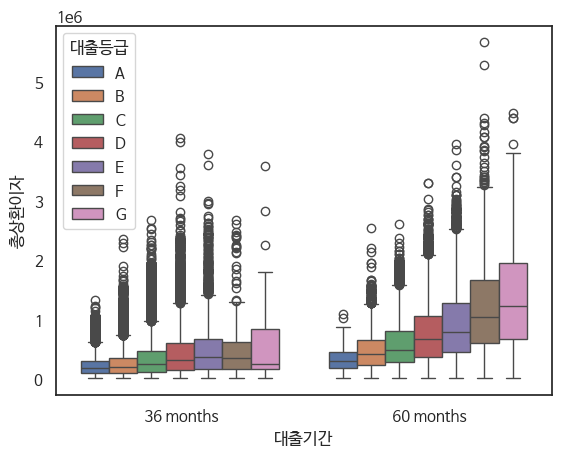

In [33]:
sns.boxplot(data=df, x="대출기간", y="총상환이자", hue="대출등급", hue_order=grade_order)

`-` 대출 등급이 낮을수록 돈을 많이 갚지 못해 이자만 쌓여 대출 금액이 더 적지만 오히려 총 상환 이자는 평균적으로 더 많다

- 대출 목적

In [35]:
pd.crosstab(df["대출등급"], df["대출목적"])

대출목적,기타,부채 통합,소규모 사업,신용 카드,의료,이사,자동차,재생 에너지,주요 구매,주택,주택 개선,휴가
대출등급,,,,,,,,,,,,
A,356,8036,19,6424,104,13,174,1,372,8,1225,40
B,1080,15680,75,8917,238,86,258,4,479,36,1845,119
C,1705,16349,249,6036,375,203,213,20,503,85,1689,196
D,916,8529,192,2092,197,131,87,21,238,68,805,78
E,478,4979,158,877,91,50,46,10,150,63,425,27
F,147,1311,64,137,27,18,15,4,53,29,145,4
G,43,266,30,17,7,5,4,0,8,12,26,2


`-` 대출 목적별로 대출 등급의 분포가 조금 다르다

- 총 계좌 수

<Axes: xlabel='대출등급', ylabel='총계좌수'>

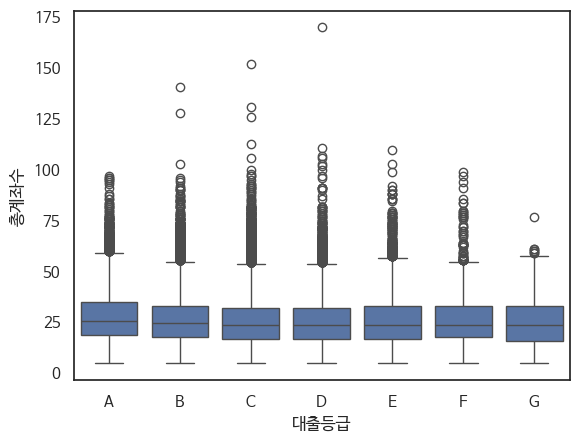

In [38]:
sns.boxplot(data=df, x="대출등급", y="총계좌수", order=grade_order)

`-` 가장 낮은 G등급의 경우 총 계좌 수의 이상치 상한이 다른 등급에 비해 작다

`-` 대출 등급과 총 계좌 수는 서로 관련이 없어 보인다

- 최근 2년간 연체 횟수

In [44]:
df["최근_2년간_연체_횟수"].value_counts().sort_index()

0     76392
1     13079
2      3896
3      1430
4       697
5       338
6       178
7        86
8        67
9        40
10       35
11       21
12        9
13        8
14        8
15        2
16        4
17        1
18        2
30        1
Name: 최근_2년간_연체_횟수, dtype: int64

In [48]:
df["대출등급"].value_counts().sort_index() / len(df)

A   0.174
B   0.299
C   0.287
D   0.139
E   0.076
F   0.020
G   0.004
Name: 대출등급, dtype: float64

In [45]:
df.query("최근_2년간_연체_횟수 == 0")["대출등급"].value_counts().sort_index() / len(df.query("최근_2년간_연체_횟수 == 0"))

A   0.188
B   0.296
C   0.280
D   0.135
E   0.076
F   0.020
G   0.004
Name: 대출등급, dtype: float64

In [46]:
df.query("최근_2년간_연체_횟수 > 0")["대출등급"].value_counts().sort_index() / len(df.query("최근_2년간_연체_횟수 > 0"))

A   0.120
B   0.312
C   0.312
D   0.152
E   0.078
F   0.021
G   0.005
Name: 대출등급, dtype: float64

`-` 대출 등급이 낮을수록 연체를 하지 않는다

- 연체 계좌수

In [59]:
df["연체계좌수"].astype(int).value_counts()

0    95762
1      507
2       24
4        1
Name: 연체계좌수, dtype: int64

In [56]:
df.query("연체계좌수 == 0")["대출등급"].value_counts().sort_index() / len(df.query("연체계좌수 == 0"))

A   0.175
B   0.300
C   0.286
D   0.138
E   0.076
F   0.020
G   0.004
Name: 대출등급, dtype: float64

In [55]:
df.query("연체계좌수 > 0")["대출등급"].value_counts().sort_index() / len(df.query("연체계좌수 > 0"))

A   0.036
B   0.252
C   0.385
D   0.201
E   0.100
F   0.023
G   0.004
Name: 대출등급, dtype: float64

`-` A등급의 경우 연체 비율에 비해 연체된 계좌가 현저히 적다

In [89]:
def correct(df):
    df["근로기간"] = df["근로기간"].replace("<1 year", "< 1 year")
    df["근로기간"] = df["근로기간"].replace("10+years", "10+ years")
    df["근로기간"] = df["근로기간"].replace("3", "3 years")
    df["근로기간"] = df["근로기간"].replace("1 years", "1 year")
    return df

In [90]:
df = correct(df)

In [69]:
df["근로기간"].value_counts().sort_index()

1 year        6305
10+ years    32481
2 years       8450
3 years       7670
4 years       5588
5 years       5665
6 years       3874
7 years       3814
8 years       4888
9 years       3744
< 1 year      8144
Unknown       5671
Name: 근로기간, dtype: int64

In [71]:
df.query("근로기간 == '10+ years'")["대출등급"].value_counts().sort_index() / len(df.query("근로기간 == '10+ years'"))

A   0.185
B   0.304
C   0.280
D   0.135
E   0.072
F   0.020
G   0.004
Name: 대출등급, dtype: float64

In [72]:
df.query("근로기간 == '< 1 year'")["대출등급"].value_counts().sort_index() / len(df.query("근로기간 == '< 1 year'"))

A   0.162
B   0.290
C   0.300
D   0.144
E   0.081
F   0.020
G   0.003
Name: 대출등급, dtype: float64

`-` 근로 기간이 길수록 대출 등급이 우수하다

`-` 이는 연봉이 높아서 그런 것으로 보인다

## 전처리

`-` 차원의 저주를 고려하여 사용할 변수는 대출 금액, 대출 기간, 주택 소유 상태, 연간 소득, 최근 2년간 연체 횟수, 총 상환 이자, 상환 비율, 대출 금액 대비 상환 이자, 연체 계좌 수이다

In [322]:
def preprocessing(df):
    df["대출기간"] = df["대출기간"].apply(lambda x: 0 if x == " 36 months" else 1)
    df["주택소유상태"] = df["주택소유상태"].apply(lambda x: 0 if x == "MORTGAGE" else 1)
    df["최근_2년간_연체_횟수"] = df["최근_2년간_연체_횟수"].apply(lambda x: 10 if x > 10 else x)
    df["연체계좌수"] = df["연체계좌수"].apply(lambda x: 1 if x >= 1 else 0)
    return df

In [323]:
vars = ["대출금액", "대출기간", "주택소유상태", "연간소득", "최근_2년간_연체_횟수", "총상환이자", "상환비율", "대출금액대비상환이자", "연체계좌수"]

In [324]:
df = preprocessing(df)
test = preprocessing(test)

- 수치형 변수 스케일링

In [325]:
scaler = RobustScaler()
numeric_columns = ["대출금액", "연간소득", "총상환이자"]
df.loc[:, numeric_columns] = scaler.fit_transform(df[numeric_columns])
test.loc[:, numeric_columns] = scaler.transform(test[numeric_columns])

- 범주형 변수 인코딩

In [326]:
goal_columns = df["대출목적"].unique().tolist()

In [327]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
categorical_column = "대출목적"
df = pd.concat([df, pd.DataFrame(onehot_encoder.fit_transform(df[[categorical_column]]), columns=onehot_encoder.categories_[0])], axis=1)
test = pd.concat([test, pd.DataFrame(onehot_encoder.transform(test[[categorical_column]]), columns=onehot_encoder.categories_[0])], axis=1)
df = df.drop(categorical_column, axis=1)
test = test.drop(categorical_column, axis=1)

- 라벨 인코딩

In [328]:
target_encoder = LabelEncoder()
target_encoder.fit(df["대출등급"])

LabelEncoder()

## 모델 학습

In [331]:
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

In [332]:
NUM_FOLDS = 5
SEED = 2024

In [333]:
y = df.pop("대출등급")
y = target_encoder.transform(y)
X = df[vars + goal_columns].to_numpy()
X_test = test[vars + goal_columns].to_numpy()

In [342]:
kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

In [343]:
test_pred = np.zeros((test.shape[0], 7))
preds_valid = []
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    early_stopping_rounds=50,
    max_depth=6,
    random_state=SEED,
)

In [344]:
for fold, (train_indices, valid_indices) in enumerate(kfold.split(X, y)):
    print(f"[{fold + 1} / {NUM_FOLDS}] Fold Training......")
    X_train, y_train = X[train_indices], y[train_indices]
    X_valid, y_valid = X[valid_indices], y[valid_indices]
    sample_weight = compute_sample_weight(
        class_weight={0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1.5, 6: 3},
        y=y_train,
    )
    xgb.fit(X_train, y_train, sample_weight=sample_weight, eval_set=[(X_valid, y_valid)], verbose=30)
    pred_valid = xgb.predict(X_valid)
    preds_valid.append(f1_score(y_valid, pred_valid, average="macro"))
    test_pred += xgb.predict_proba(X_test) / NUM_FOLDS

[1 / 5] Fold Training......
[0]	validation_0-mlogloss:1.82449
[30]	validation_0-mlogloss:0.57798
[60]	validation_0-mlogloss:0.29350
[90]	validation_0-mlogloss:0.20784
[120]	validation_0-mlogloss:0.17839
[150]	validation_0-mlogloss:0.16750
[180]	validation_0-mlogloss:0.16161
[210]	validation_0-mlogloss:0.15766
[240]	validation_0-mlogloss:0.15514
[270]	validation_0-mlogloss:0.15295
[299]	validation_0-mlogloss:0.15156
[2 / 5] Fold Training......
[0]	validation_0-mlogloss:1.82232
[30]	validation_0-mlogloss:0.58374
[60]	validation_0-mlogloss:0.29649
[90]	validation_0-mlogloss:0.20904
[120]	validation_0-mlogloss:0.17874
[150]	validation_0-mlogloss:0.16778
[180]	validation_0-mlogloss:0.16144
[210]	validation_0-mlogloss:0.15796
[240]	validation_0-mlogloss:0.15557
[270]	validation_0-mlogloss:0.15389
[299]	validation_0-mlogloss:0.15280
[3 / 5] Fold Training......
[0]	validation_0-mlogloss:1.82212
[30]	validation_0-mlogloss:0.57692
[60]	validation_0-mlogloss:0.29040
[90]	validation_0-mlogloss:0.2

In [352]:
preds_valid

[0.91551725105305,
 0.9184233694744288,
 0.9064873416726543,
 0.9230753815567784,
 0.9262651700624245]

In [346]:
pred = test_pred.argmax(-1)
pred = target_encoder.inverse_transform(pred)

In [348]:
submission["대출등급"] = pred
submission.to_csv("./data/submission-1.csv", index=False)

In [350]:
submission["대출등급"].value_counts().sort_index()

A    11198
B    19477
C    18798
D     8488
E     4642
F     1300
G      294
Name: 대출등급, dtype: int64